In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = 12,6

## Define Constants

In [3]:
L = 21 # length of filter
SeqLen = 1000 # length of test data
SNR = 10

lms_mu = 0.05

nlms_mu = 1
delta = 1e-3

beta = .1
reg = 1e-1

## Generate Input Data

Run random data through a low-pass filter. LMS with same number of taps should be pretty good at guessing LPF response.

In [4]:
h = np.array([
    -0.02010411882885732,
    -0.05842798004352509,
    -0.061178403647821976,
    -0.010939393385338943,
    0.05125096443534972,
    0.033220867678947885,
    -0.05655276971833928,
    -0.08565500737264514,
    0.0633795996605449,
    0.310854403656636,
    0.4344309124179415,
    0.310854403656636,
    0.0633795996605449,
    -0.08565500737264514,
    -0.05655276971833928,
    0.033220867678947885,
    0.05125096443534972,
    -0.010939393385338943,
    -0.061178403647821976,
    -0.05842798004352509,
    -0.02010411882885732,
])

In [5]:
d

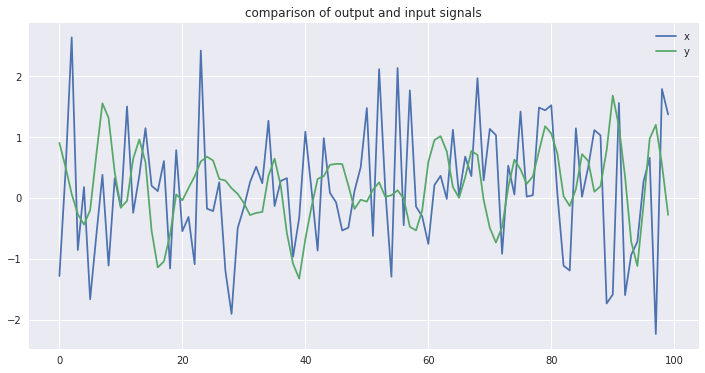

In [6]:
plt.plot(x[L:100+L], label="x")
plt.plot(y[:100], label="y")
plt.title("comparison of output and input signals")
plt.legend()

Confirm that low pass filter is working

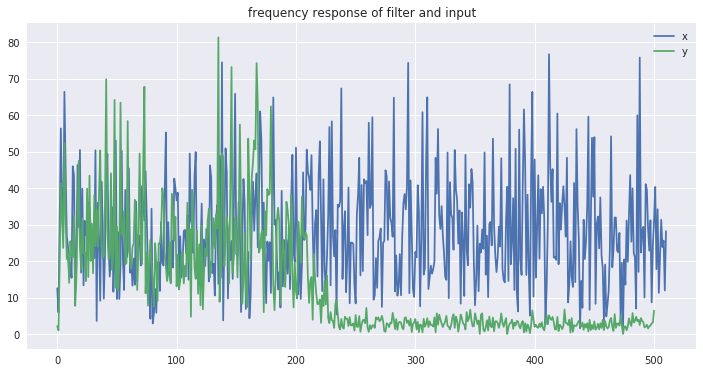

In [7]:
plt.plot(abs(np.fft.rfft(x)), label="x")
plt.plot(abs(np.fft.rfft(y)), label="y")
plt.title("frequency response of filter and input")
plt.legend()

# Create and use filters

In [10]:
class LMS:
    """ Least mean squares filter
        Arguments:
            L : length of filter in samples
            mu: learning rate of filter
    """
    def __init__(self, L, mu):
        self.w = np.zeros(L)
        self.mu = mu
        
    def process(self, X, y):
        yhat = self.w.T@X
        e = y-yhat
        self.w += self.mu * e * X
        mse = e**2
        return mse, yhat

In [11]:
class NLMS:
    """ NLMS filter class
        Arguments:
            L     : length of filter in samples
            mu    : learning rate of filter
            delta : factor to add for numerical stability
            
    """
    def __init__(self, L, mu, delta):
        self.w = np.zeros(L)
        self.mu = mu
        self.delta = delta
        
    def process(self, X, y):
        yhat = np.dot(self.w, X)
        e = y-yhat
        nu = self.mu / (self.delta + np.dot(X, X))
        self.w += nu * e * X
        mse = e**2
        return mse, yhat

In [12]:
class RLS:
    """ Recursive least squares filter
        Arguments:
            L    : length of filter in samples
            beta : forgetting factor
            reg  : regularization factor
    """
    def __init__(self, L, beta, reg):
        self.w = np.zeros(L)
        self.beta = beta
        self.reg  = reg
        self.P = 1/reg*np.eye(L,L)
        
    def process(self, X, y):
        yhat = np.dot(self.w.T, X)
        e = y-yhat
        
        num = np.dot(np.dot(np.dot(self.P,X),X.T),self.P)
        denom = self.beta + np.dot(np.dot(X,self.P),X.T)
        
        self.P = 1/self.beta * (self.P - num/denom)
        self.w += e*(self.P@X.T)
        mse = e**2
        return mse, yhat

In [13]:
lms = LMS(L,lms_mu)
nlms = NLMS(L, nlms_mu, delta)
rls = RLS(L, beta, reg)

In [14]:
yhat_lms  = np.zeros(y.shape)
yhat_nlms = np.zeros(y.shape)
yhat_rls  = np.zeros(y.shape)
es_lms    = np.zeros(y.shape)
es_nlms   = np.zeros(y.shape)
es_rls    = np.zeros(y.shape)
for i in range(SeqLen):
    es_lms[i], yhat_lms[i] = lms.process(x[i:i+L], y[i])
    es_nlms[i], yhat_nlms[i] = nlms.process(x[i:i+L], y[i])
    es_rls[i], yhat_rls[i] = rls.process(x[i:i+L], y[i])

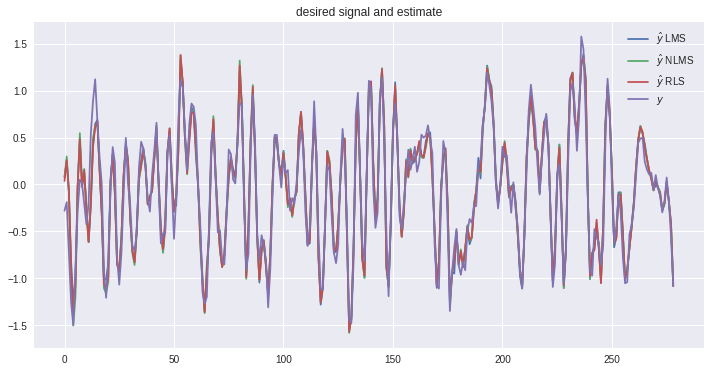

In [15]:
npoints = 300
plt.plot(yhat_lms[L:npoints], label=r"$\hat{y}$ LMS")
plt.plot(yhat_nlms[L:npoints], label=r"$\hat{y}$ NLMS")
plt.plot(yhat_rls[L:npoints], label=r"$\hat{y}$ RLS")
plt.plot(y[L:npoints], label=r"$y$")
plt.title("desired signal and estimate")
plt.legend()

Text(0.5, 1.0, 'MSE')

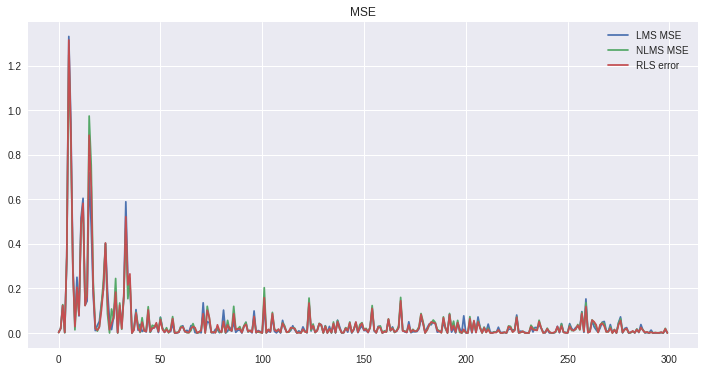

In [16]:
nerrors = 300
plt.plot( es_lms[:nerrors], label="LMS MSE")
plt.plot(es_nlms[:nerrors], label="NLMS MSE")
plt.plot( es_rls[:nerrors], label="RLS error")
plt.legend()
plt.title("MSE")

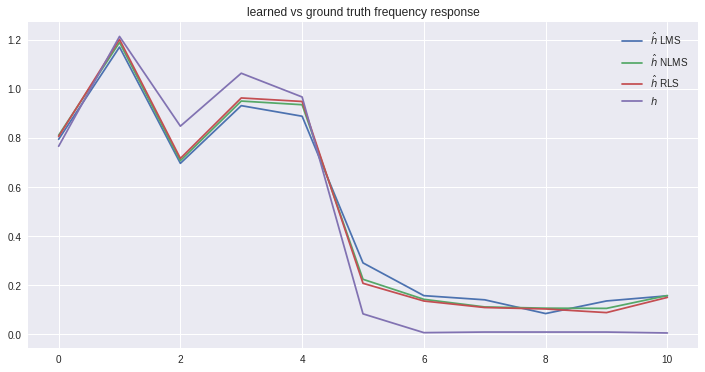

In [17]:
plt.plot(np.abs(np.fft.rfft(lms.w)), label=r"$\hat{h}$ LMS")
plt.plot(np.abs(np.fft.rfft(nlms.w)), label=r"$\hat{h}$ NLMS")
plt.plot(np.abs(np.fft.rfft(rls.w)), label=r"$\hat{h}$ RLS")
plt.plot(np.abs(np.fft.rfft(h)), label=r"$h$")
plt.title("learned vs ground truth frequency response")
plt.legend()

# Inspect Loss from C++ Implementation


This section inspects the `.csv` files exported by the c++ testbench

In [5]:
import pandas as pd

In [7]:
lmsf = "./hls/lms_classes/solution1/csim/build/LMS_MSEs.csv"
nlmsf = "./hls/nlms_classes/solution1/csim/build/NLMS_MSEs.csv"
lmsdf = pd.read_csv(lmsf)
nlmsdf = pd.read_csv(nlmsf)

FileNotFoundError: File b'./hls/nlms_classes/solution1/csim/build/NLMS_MSEs.csv' does not exist

In [ ]:
df = nlmsdf

In [ ]:
nt = 200
plt.plot(np.array(df.x[:nt]), label="x")
plt.plot(np.array(df.y[:nt]), label="y")
plt.legend()

In [ ]:
plt.plot(abs(np.fft.rfft(df.x)))
plt.plot(abs(np.fft.rfft(df.y)))

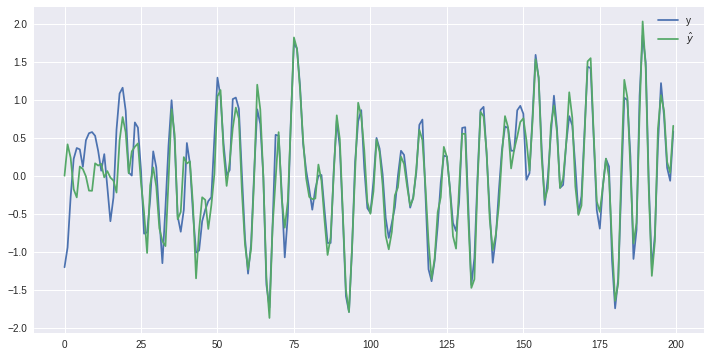

In [1402]:
plt.plot(df.y[:nt], label='y')
plt.plot(df.yhat[:nt], label=r'$\hat{y}$')
plt.legend()

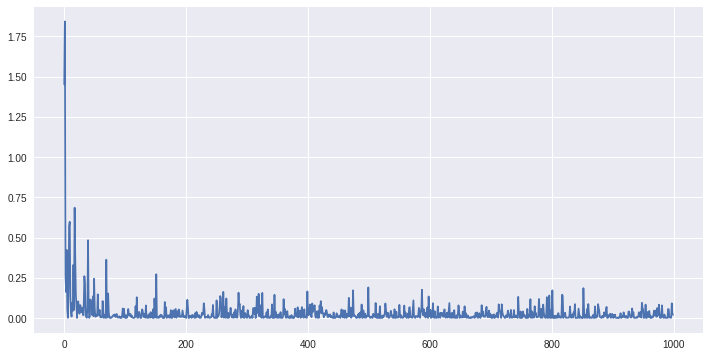

In [1403]:
plt.plot(df.MSE)